##Libraries

In [1]:
# Install required packages
!pip install roboflow
!pip install monai
!pip install segment-geospatial
!pip install pycocotools

In [2]:
# Import necessary libraries
from roboflow import Roboflow
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
from transformers import SamModel, SamProcessor
import leafmap
import monai
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.optim import Adam

## Download dataset

In [3]:
rf = Roboflow(api_key="5nAESdZUJDBa6zqZaEpG")
project = rf.workspace("satellite-iteka").project("merged-nyakw")
version = project.version(3)
dataset = version.download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Merged-3 in coco-segmentation:: 100%|██████████| 178/178 [00:00<00:00, 1519.44it/s]


##Load Image and Polygon

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

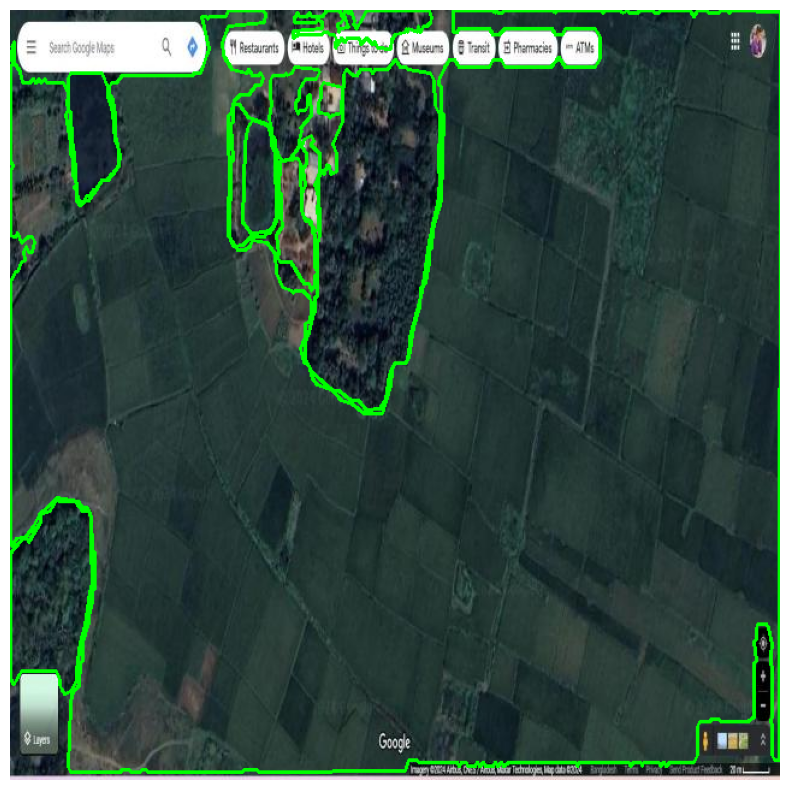

In [4]:
# Define dataset paths
train_images_path = '/content/Merged-3/train/'
train_annotations_path = '/content/Merged-3/train/_annotations.coco.json'

# Load COCO annotations
coco = COCO(train_annotations_path)

# Get all image IDs
image_ids = coco.getImgIds()

# Initialize the SAM processor and model
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
model = SamModel.from_pretrained("facebook/sam-vit-base")

# Move the model to the correct device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Function to visualize images and polygon annotations
def display_image_and_polygons(coco, image_id):
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(train_images_path, image_info['file_name'])
    image = cv2.imread(image_path)

    # Load annotations for the image
    annotation_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotation_ids)

    # Draw polygon annotations
    for ann in annotations:
        segmentation = ann['segmentation']
        for seg in segmentation:
            poly_points = np.array(seg).reshape((-1, 2))
            cv2.polylines(image, [np.int32(poly_points)], isClosed=True, color=(0, 255, 0), thickness=2)

    # Show the image with the polygons
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Example to display the first image with polygon annotations
display_image_and_polygons(coco, image_ids[0])

# Function to load image and polygons
def load_image_and_polygons(image_id, coco):
    # Load image metadata and path
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(train_images_path, image_info['file_name'])
    image = cv2.imread(image_path)

    # Resize image to a smaller size if necessary
    image = cv2.resize(image, (256, 256))

    # Load polygons (annotations) for the image
    ann_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(ann_ids)

    polygons = []
    for ann in annotations:
        for seg in ann['segmentation']:
            polygons.append(np.array(seg).reshape(-1, 2))

    return image, polygons

##SAM DATASET

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.cuda.amp import autocast, GradScaler
from PIL import Image
import os
import cv2
import numpy as np


coco = COCO(train_annotations_path)


# Assuming you are using a model similar to SAM (Segment Anything Model)
# Modify the output layer to accommodate 8 classes
num_classes = 8

# Model's forward pass should now output a tensor of shape [batch_size, num_classes, height, width]
# Ensure the final output layer uses a softmax or log_softmax activation
class SAMModel(nn.Module):
    def __init__(self):
        super(SAMModel, self).__init__()
        # Define your model layers here, using num_classes for the final output layer
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

        # Output layer for segmentation (logits, no activation yet)
        self.final_conv = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        # Pass input through the model
        x = self.encoder(x)
        x = self.decoder(x)
        logits = self.final_conv(x)  # Output shape: [batch_size, num_classes, height, width]
        return logits

# Custom Dataset Class (adjust as needed)
class SAMDataset(torch.utils.data.Dataset):
    def __init__(self, coco, processor, train_images_path):
        self.coco = coco
        self.processor = processor
        self.image_ids = self.coco.getImgIds() # Get all image IDs
        self.train_images_path = train_images_path  # Add path for image loading

    def __len__(self):
        return len(self.image_ids) # Return the number of images

    def __getitem__(self, idx):
        # Load image and corresponding ground truth mask here
        image_id = self.image_ids[idx]  # Get the image ID for the current index

        # Load image using COCO API and OpenCV
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.train_images_path, image_info['file_name'])
        image = Image.open(image_path).convert("RGB")  # Load image with PIL and convert to RGB

        # Load polygons (annotations) for the image
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(ann_ids)

        # Process image using SAM processor
        # Assuming processor.image_processor and processor.__call__ are the correct methods
        # Adjust as needed based on your processor's functionality
        inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = inputs.pixel_values

        # Create mask from polygon annotations
        mask = np.zeros((image.size[1], image.size[0]), dtype=np.uint8) # Initialize mask with zeros
        for ann in annotations:
            segmentation = ann['segmentation']
            for seg in segmentation:
                poly_points = np.array(seg).reshape((-1, 2)).astype(int) # Convert polygon points to integers
                cv2.fillPoly(mask, [poly_points], 1) # Fill polygon area in the mask with 1

        ground_truth_mask = torch.tensor(mask, dtype=torch.long)  # Ensure mask is of shape [height, width] with int labels

        return pixel_values.squeeze(0), ground_truth_mask # Remove batch dimension

# Collate function to batch data
def collate_fn(batch):
    pixel_values, ground_truth_masks = zip(*batch)
    pixel_values = torch.stack(pixel_values)
    ground_truth_masks = torch.stack(ground_truth_masks)
    return {'pixel_values': pixel_values, 'ground_truth_mask': ground_truth_masks}

# Initialize dataset and dataloader
train_dataset = SAMDataset(coco=coco, processor=processor, train_images_path=train_images_path)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

# Training loop
model = SAMModel().cuda()
optimizer = Adam(model.parameters(), lr=1e-5)
scaler = GradScaler()

# Loss function (CrossEntropyLoss for multi-class segmentation)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 25
accumulation_steps = 2  # Adjust if needed for gradient accumulation

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        pixel_values = batch['pixel_values'].cuda()  # Shape: [batch_size, channels, height, width]
        ground_truth_mask = batch['ground_truth_mask'].cuda()  # Shape: [batch_size, height, width]

        with autocast():
            logits = model(pixel_values)  # Shape: [batch_size, num_classes, height, width]

            # Resize ground truth masks to the predicted mask size
            target_size = logits.shape[-2:]  # [height, width] of predicted output
            ground_truth_mask = F.interpolate(ground_truth_mask.unsqueeze(1).float(), size=target_size, mode='nearest').squeeze(1).long()

            # Compute loss
            loss = loss_fn(logits, ground_truth_mask)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_dataloader)}')

print('Training complete.')


loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
Epoch 1, Loss: 2.1454250887036324
Epoch 2, Loss: 2.0945134796202183
Epoch 3, Loss: 2.037360648624599
Epoch 4, Loss: 1.972899536602199
Epoch 5, Loss: 1.9023942183703184
Epoch 6, Loss: 1.8242466617375612
Epoch 7, Loss: 1.7392084691673517
Epoch 8, Loss: 1.651916529983282
Epoch 9, Loss: 1.5659676529467106
Epoch 10, Loss: 1.483411742374301
Epoch 11, Loss: 1.4052802259102464
Epoch 12, Loss: 1.3333190279081464
Epoch 13, Loss: 1.2670512134209275
Epoch 14, Loss: 1.2068993281573057
Epoch 15, Loss: 1.152171840891242
Epoch 16, Loss: 1.1030209949240088
Epoch 17, Loss: 1.0588584556244314
Epoch 18, Loss: 1.0186486230231822
Epoch 19, Loss: 0.9824135899543762
Epoch 20, Loss: 0.9495533215813339
Epoch 21, Loss: 0.9200631752610207
Epoch 22, Loss: 0.8932627877220511
Epoch 23, Loss: 0.8689829986542463
Epoch 24, Loss: 0.8470277232117951
Epoch 25, Loss: 0.8270967970602214
Training complete.


In [6]:

# Save the trained model after training is complete
import torch

# Path to save the trained model
model_save_path = "trained_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved at {model_save_path}")


Model saved at trained_model.pth


In [7]:

# Load the saved model for inference
model = SAMModel()  # Ensure model structure matches the saved model
model.load_state_dict(torch.load("trained_model.pth"))
model.eval()  # Set to evaluation mode
model.to(device)  # Move model to appropriate device
print("Model loaded and ready for inference.")


Model loaded and ready for inference.


In [8]:

# Example inference on test data (replace test_dataset with actual test data if available)
test_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)  # Modify dataset as needed

# Collect predictions
all_predictions = []
all_ground_truths = []

with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch['pixel_values'].to(device)
        ground_truth_mask = batch['ground_truth_mask'].to(device)

        # Get model predictions
        logits = model(pixel_values)
        preds = torch.argmax(logits, dim=1)  # Predicted class for each pixel

        all_predictions.append(preds.cpu())
        all_ground_truths.append(ground_truth_mask.cpu())

print("Inference completed on test data.")


Inference completed on test data.


In [10]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Ensure all predictions and ground truths are reshaped correctly
flat_preds = np.concatenate([pred.numpy().flatten() for pred in all_predictions])
flat_truths = np.concatenate([truth.numpy().flatten() for truth in all_ground_truths])

# Adjust if there are mismatched sizes
min_length = min(len(flat_preds), len(flat_truths))
flat_preds, flat_truths = flat_preds[:min_length], flat_truths[:min_length]

# Calculate accuracy and classification report
accuracy = accuracy_score(flat_truths, flat_preds)
report = classification_report(flat_truths, flat_preds, zero_division=1)

print("Model Evaluation Results:")
print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Model Evaluation Results:
Accuracy: 0.7010214614868164
Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.06      0.09  14208907
           1       0.73      0.94      0.82  38219893

    accuracy                           0.70  52428800
   macro avg       0.50      0.50      0.46  52428800
weighted avg       0.60      0.70      0.62  52428800



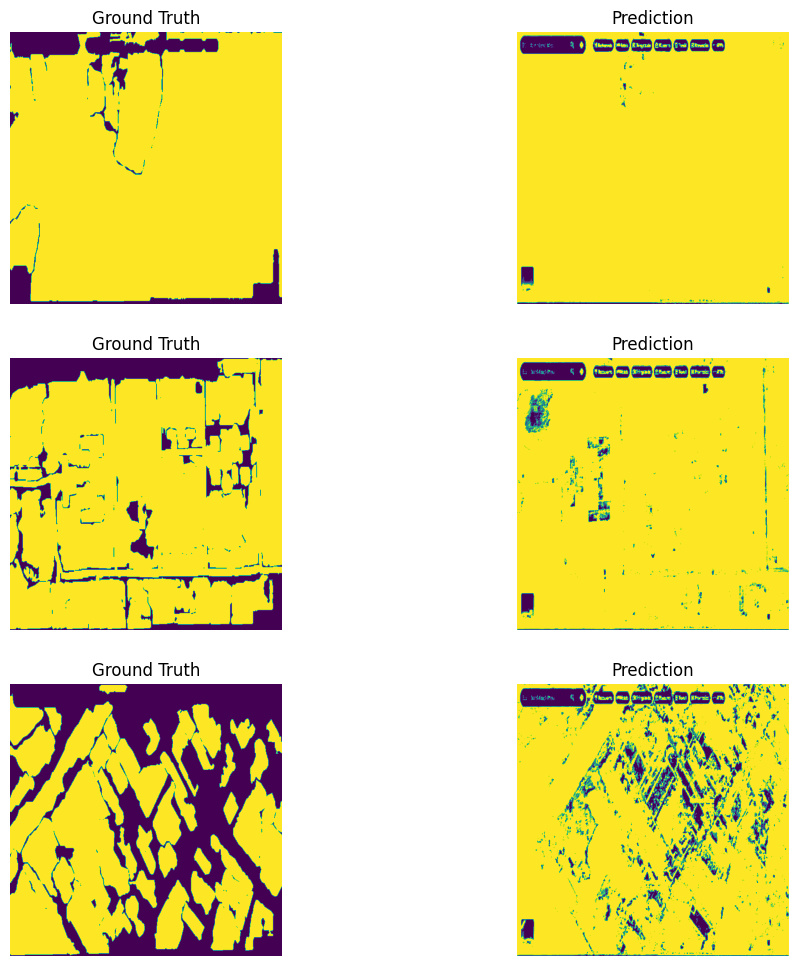

In [11]:

import matplotlib.pyplot as plt

# Visualize a few predictions versus ground truths
num_samples = 3  # Adjust number of samples for EDA

plt.figure(figsize=(12, 4 * num_samples))
for i in range(num_samples):
    # Display ground truth
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.title("Ground Truth")
    plt.imshow(all_ground_truths[i][0].numpy(), cmap="viridis")
    plt.axis("off")

    # Display model prediction
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.title("Prediction")
    plt.imshow(all_predictions[i][0].numpy(), cmap="viridis")
    plt.axis("off")

plt.show()
